In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses, plot_train_val_evaluators
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model
from tqdm import tqdm

from data.constants import  DEFAULT_REFLACX_LABEL_COLS
from data.paths import XAMI_MIMIC_PATH

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

from utils.eval import get_thrs_evaluation_df, plot_iou_result, showModelOnDatasets, showModelOnScoreThrs,  showModelsOnDatasets, get_mAP_mAR

# plot_training_progress, print_num_params,
# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
``

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):
    # CXR_images="val_ar_0_0487_ap_0_0112_test_ar_0_0494_ap_0_0124_epoch100_11-07-2022 19-23-44_All_label_testing"    
    CXR_image_5_labels = "val_ar_0_5178_ap_0_2403_test_ar_0_5277_ap_0_2606_epoch50_11-17-2022 08-48-30_label_testing"
    CXR_image_6_labels = "val_ar_0_5650_ap_0_2376_test_ar_0_5607_ap_0_2611_epoch80_11-20-2022 09-39-54_label_testing"
    CXR_image_5_labels_groundglass_opacity = "val_ar_0_2357_ap_0_0475_test_ar_0_2608_ap_0_0488_epoch40_11-21-2022 20-46-57_label_testing"
    CXR5andLMandGO = "val_ar_0_1868_ap_0_0314_test_ar_0_2216_ap_0_0421_epoch10_11-26-2022 20-33-47_label_testing"
    # CXR_images_pupil="val_ar_0_3786_ap_0_1456_test_ar_0_4015_ap_0_1718_epoch26_09-19-2022 02-32-59_CXR_images_pupil"
    # CXR_images_fixations= "val_ar_0_3871_ap_0_1611_test_ar_0_3508_ap_0_1405_epoch30_09-21-2022 08-45-03_CXR_images_fixations"
    # CXR_images_resnet= "val_ar_0_6295_ap_0_2233_test_ar_0_6295_ap_0_2365_epoch13_10-05-2022 05-28-54_CXR_images_resnet"
    # CXR_images_fixations_multiply= "val_ar_0_2275_ap_0_1134_test_ar_0_2464_ap_0_1187_epoch16_10-07-2022 09-07-36_CXR_images__fixations_multiply"
    # CXR_images_1third= "val_ar_0_1143_ap_0_0292_test_ar_0_1206_ap_0_0349_epoch14_09-22-2022 16-58-38_CXR_images_fixations_1third"
    # CXR_images_fixations_mobilenet = "val_ar_0_0552_ap_0_0182_test_ar_0_0622_ap_0_0138_epoch11_10-09-2022 03-42-33_CXR_images_fixations_mobilenet"
    # CXR_images_fixations_resnet = "val_ar_0_2876_ap_0_1181_test_ar_0_3026_ap_0_1391_epoch23_10-11-2022 06-58-51_CXR_images_fixations_resnet"
    # CXR_images_pupil_multiply = "val_ar_0_3076_ap_0_1231_test_ar_0_3568_ap_0_1647_epoch9_10-16-2022 01-28-41_CXR_images_pupil_multiply"
    # CXR_images_fixations_1third_multiply = "val_ar_0_1789_ap_0_0894_test_ar_0_1432_ap_0_0704_epoch26_10-18-2022 21-24-52_CXR_images_fixations_1third_multiply"
    # CXR_images_fixations_2third_multiply = "val_ar_0_1052_ap_0_0364_test_ar_0_0927_ap_0_0367_epoch4_10-19-2022 16-24-41_CXR_images_fixations_2third_multiply"




In [4]:
naming_map = {
    TrainedModels.CXR_image_5_labels: "CXR_image_5_labels",
    TrainedModels.CXR_image_6_labels: "CXR_image_6_labels",
    TrainedModels.CXR_image_5_labels_groundglass_opacity: "top5 with GO",
    TrainedModels.CXR5andLMandGO: "CXR5andLMandGO"
    # TrainedModels.CXR_images_fixations_multiply: "CXR_fixations",
    # TrainedModels.CXR_images_pupil_multiply: "CXR_pupil",
    # TrainedModels.CXR_images_fixations_1third_multiply: "CXR_fixations_1third",
    # TrainedModels.CXR_images_fixations_2third_multiply: "CXR_fixations_2third",
}


In [5]:
models_to_generate = [
    TrainedModels.CXR5andLMandGO
]

In [6]:
for select_model in tqdm(models_to_generate):

    model, train_info, _, _ = get_trained_model(
            select_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.5,
        )

    print(train_info)

  0%|          | 0/1 [00:00<?, ?it/s]

Using pretrained backbone. mobilenet_v3
label_testing will use mask, [64] layers.


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

Using SGD as optimizer with lr=0.001
========================================For Training [label_testing]========================================
ModelSetup(name='label_testing', use_heatmaps=False, with_fixations=False, with_pupil=False, with_1st_third_fixations=False, with_2nd_third_fixations=False, with_rad_silence=False, with_rad_speaking=False, save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=True, image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, fusion_strategy='add', fusion_residule=False, gt_in_t

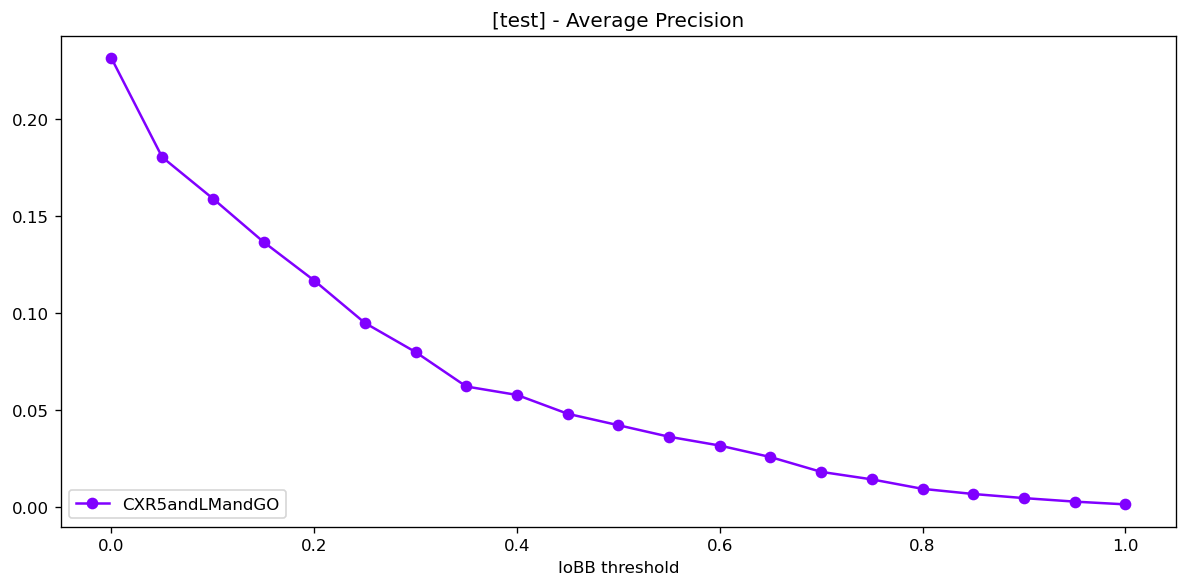

In [7]:
_ = plot_iou_result(
    models_to_generate,
    ["test"], #["train", "val", "test"],
    naming_map,
    figsize=(10, 5),
    include_recall=False,
    score_thrs=0.05,
)

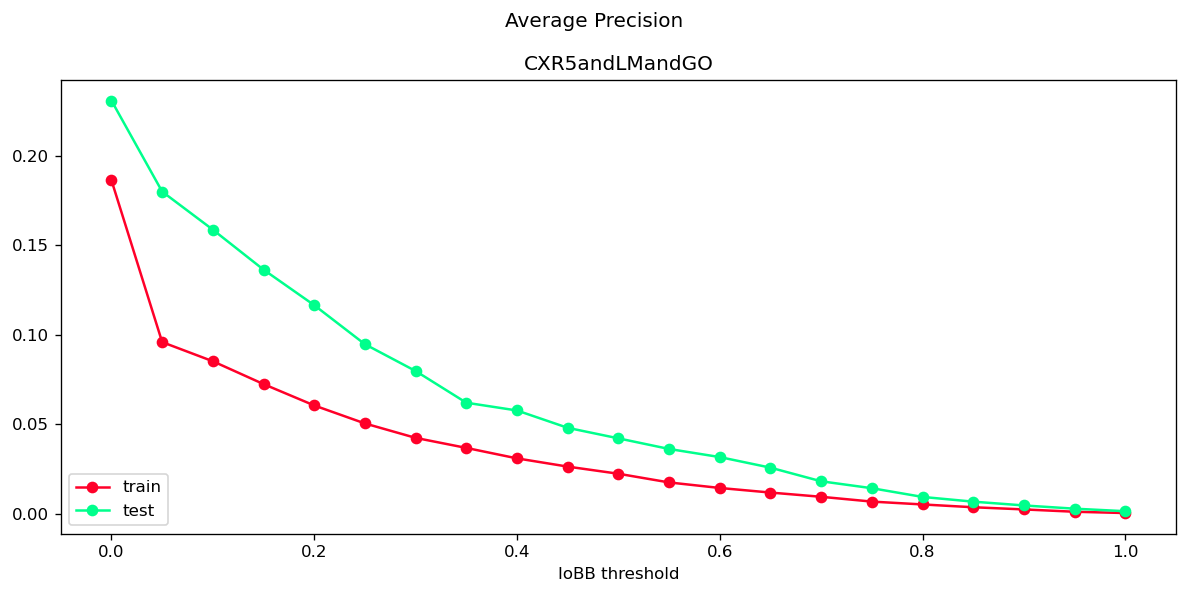

In [8]:
axes = showModelsOnDatasets(
   models_to_generate,
    ["train", "test"],  # ["train", "val", "test"]
    naming_map,
    figsize=(10, 5),
    score_thrs=0.05,
)



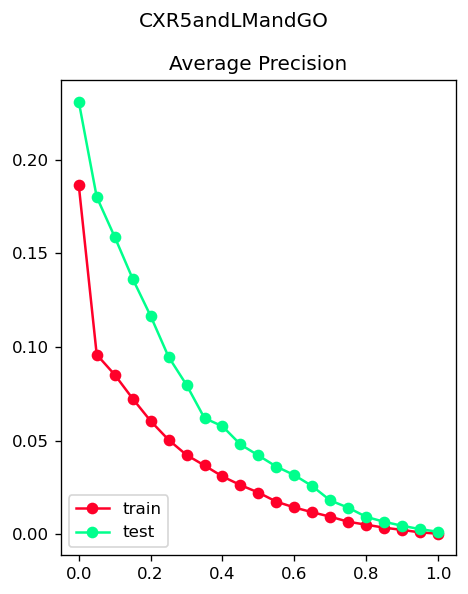

In [9]:
for model in models_to_generate:
    _ = showModelOnDatasets(
        model,
        ["train", "test"],  # ["train", "val", "test"]
        naming_map,
        figsize=(4,5),
        score_thrs=0.05,
    )



In [10]:
merged_df = get_mAP_mAR(
    models= models_to_generate,
    datasets= ["test"],#["train", "val", "test"],
    naming_map=naming_map,
    score_thrs= 0.05,
)

====================Dataset [test]====================


,disease,AP@[IoBB = 0.50]_CXR5andLMandGO,AR@[IoBB = 0.50]_CXR5andLMandGO
0,Lung nodule or mass,0.006129,0.019231
1,Groundglass opacity,0.061179,0.450000
2,Pulmonary edema,0.087755,0.328947
3,Enlarged cardiac silhouette,0.001222,0.052632
4,Consolidation,0.054408,0.257310
5,Atelectasis,-1.000000,-1.000000
6,Pleural abnormality,-1.000000,-1.000000
7,all,0.042139,0.221624
